In [1]:
import numpy
import monai

/home1/ajoshi/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home1/ajoshi/.conda/envs/mypy/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [6]:
import glob
import nibabel as nib
import numpy as np
from os.path import isfile
import datetime
from IPython.display import clear_output

uncorr_files = glob.glob('/project/ajoshi_27/rodent_bfc_data4ML/data4ML2/*uncorr.nii.gz')
print(uncorr_files)


for f in uncorr_files:
  sub_name = f[:-14]

  corr_file = sub_name + '_corr.nii.gz'
  uncorr_file = sub_name + '_uncorr.nii.gz'
  output_file = sub_name + '_bias.nii.gz'

  if isfile(output_file):
    continue

  print(sub_name)

  # Load the NIfTI images using nibabel
  image1 = nib.load(corr_file).get_fdata()
  image2 = nib.load(uncorr_file).get_fdata().squeeze()



  #when we augment, make sure that the log domain is correctly accounted for

  # Calculate the ratio of the two images
  ratio = np.divide(image2, image1 + 0.1, out=np.zeros_like(image2) ) # added 0.1 to avoid division by 0

  # Save the ratio as a NIfTI file
  ratio_image = nib.Nifti1Image(ratio, affine=nib.load(uncorr_file).affine)  # Assuming no affine transformation
  nib.save(ratio_image, output_file)

  print(f"Ratio image saved as {output_file}")


clear_output()


In [3]:
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting

#from nilearn.plotting import plot_anat

nifti_file1 = '/project/ajoshi_27/rodent_bfc_data4ML/data4ML2/eae14_08_20_uncorr.nii.gz'
nifti_file2 = '/project/ajoshi_27/rodent_bfc_data4ML/data4ML2/eae14_08_20_corr.nii.gz'
nifti_file3 = '/project/ajoshi_27/rodent_bfc_data4ML/data4ML2/eae14_08_20_bias.nii.gz'

# Load the NIfTI file
#nifti_img = nib.load(nifti_file)

# Plot the image using nilearn
#plotting.view_img(nifti_file1, bg_img=False, cmap='gray', colorbar=True, symmetric_cmap=False)

plotting.plot_anat(nifti_file1, colorbar=True,vmax=2e4,vmin=0,black_bg='k')

ModuleNotFoundError: No module named 'matplotlib'

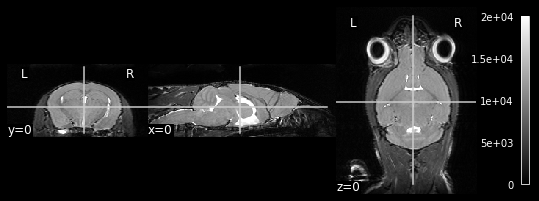

In [ ]:
plotting.plot_anat(nifti_file2, colorbar=True, vmax=2e4,vmin=0)

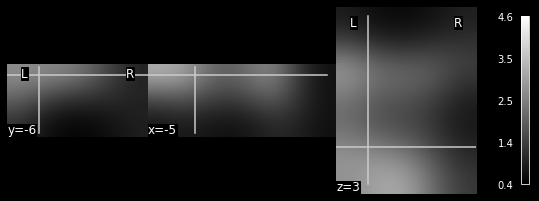

In [ ]:
plotting.plot_anat(nifti_file3, colorbar=True)

In [ ]:
import torch
import monai
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from torch.nn import MSELoss
from monai.data import Dataset, DataLoader, partition_dataset

from monai.transforms import Compose, LoadImaged, AddChanneld, SqueezeDim, SqueezeDimd, ToTensord,LoadImage,AddChannel,ToTensor,EnsureChannelFirstD,EnsureChannelFirst, Resize, RandBiasFieldd
from monai.utils import set_determinism
from glob import glob
import random

# Set random seed for reproducibility
set_determinism(seed=0)

# Define your dataset and data loader
class BiasFieldCorrectionDataset(Dataset):
    def __init__(self, image_files, bias_files, transform=None):
        self.image_files = image_files
        self.bias_files = bias_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image = self.transform(self.image_files[idx])
        bias = self.transform(self.bias_files[idx])
        return {'image': image, 'bias': bias}

# Assuming you have a list of paired image and bias file paths
#image_files = ['image1.nii.gz', 'image2.nii.gz']
#bias_files = ['bias_field1.nii.gz', 'bias_field2.nii.gz']

image_files = (glob('/project/ajoshi_27/rodent_bfc_data4ML/data4ML2/*uncorr.nii.gz'))
bias_files = (glob('/project/ajoshi_27/rodent_bfc_data4ML/data4ML2/*bias.nii.gz'))

# Define transformations
#transforms = Compose([LoadImaged(keys=['image', 'bias'],image_only=True), AddChanneld(keys=['image', 'bias']), ToTensord(keys=['image', 'bias'])])
#transforms = Compose([LoadImage(image_only=True), Resize(), EnsureChannelFirst(), ToTensor()])


data_dicts = [{"image": image, "bias": bias} for image, bias in zip(image_files, bias_files)]

random.seed(11)

#random.shuffle(data_dicts)
num_files = len(data_dicts)
num_train_files = round(0.8 * num_files)
train_files = data_dicts[:num_train_files]
val_files = data_dicts[num_train_files:]
print("total num files:", len(data_dicts))
print("num training files:", len(train_files))
print("num validation files:", len(val_files))



total num files: 28
num training files: 22
num validation files: 6


In [ ]:
print(train_files)
print(val_files)

print('Val file dim')
for f in val_files:
    print(nib.load(f['image']).shape)
    print(nib.load(f['bias']).shape)

print('Training file dim')
for f in train_files:
    print(nib.load(f['image']).shape)
    print(nib.load(f['bias']).shape)


[{'image': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/4_LC_uncorr.nii.gz', 'bias': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/2_BC_bias.nii.gz'}, {'image': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/6_BC_uncorr.nii.gz', 'bias': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/xtraF_LC_bias.nii.gz'}, {'image': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/4_RC_uncorr.nii.gz', 'bias': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/5_BC_bias.nii.gz'}, {'image': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/1_LCRP_uncorr.nii.gz', 'bias': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/4_RC_bias.nii.gz'}, {'image': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/xtraF_BC_uncorr.nii.gz', 'bias': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/4_RCLP_bias.nii.gz'}, {'image': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/5_LC_uncorr.nii.gz', 'bias': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/3_RC_bias.nii.gz'}, {'image': '/project/ajoshi_27/rodent_bfc_data4ML/data4ML/1_RCLP_uncor

In [ ]:

"""
# Define transformations, including resizing to
x64x64
transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
   # RandBiasField(prob=1, coeff_range=(0.2,0.3)),
    Resize(spatial_size=(64, 64, 64)),
    ToTensor(),
])
"""
from monai.transforms import Compose, Resized, RandBiasFieldd, LoadImaged, AddChanneld, EnsureChannelFirstd, RandAffined, ToTensord,LoadImage,AddChannel,ToTensor,EnsureChannelFirstD,EnsureChannelFirst, Resize, RandBiasFieldd
from monai.data import (
    CacheDataset,
    DataLoader,
    Dataset,
    pad_list_data_collate,
    TestTimeAugmentation,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


keys = ["image", "bias"]

train_transforms = Compose([
    LoadImaged(keys,image_only=True),
    EnsureChannelFirstd(keys),    
    RandAffined(
            keys,
            prob=0.5,
            rotate_range=(np.pi / 3, np.pi / 3, np.pi / 3),
            translate_range=(30,30,30),
            scale_range=(0.3,0.3,0.3),
            padding_mode=("zeros","reflection"),
        ),
    Resized(
            keys,
            spatial_size=(64, 64, 64),
    ),
    RandBiasFieldd(keys,prob=.5, coeff_range=(0,0.1)),
])


val_transforms = Compose([
    LoadImaged(keys,image_only=True),
    EnsureChannelFirstd(keys),    
    Resized(
            keys,
            spatial_size=(64, 64, 64),
    ),
])



train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=4, num_workers=10, collate_fn=pad_list_data_collate)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=10, collate_fn=pad_list_data_collate)



# Create dataset and data loader
#dataset = BiasFieldCorrectionDataset(image_files, bias_files, transform=transforms)


# Split the dataset into training and validation sets


# Create data loaders for training and validation
#train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Define the UNet model and optimizer

# Specify spatial_dims and strides for 3D data
spatial_dims = 3
strides = (1, 1, 1, 1)

model = UNet(
    spatial_dims=spatial_dims,
    in_channels=1,  # Adjust based on your data
    out_channels=1, # Adjust based on your data
    channels=(2,8,8,16,32),#(16, 64, 64, 128, 256),
    strides=strides,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Define the Dice loss
loss_function = MSELoss() # DiceLoss(sigmoid=True)

# Training loop
num_epochs = 500

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0

    for batch in train_loader:

        inputs, biases = batch['image'].to(device), torch.log(batch['bias']).to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_function(outputs, biases)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_train_loss / len(train_loader)}")


    # Validation loop
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            inputs, biases = batch['image'].to(device), torch.log(batch['bias']).to(device)
            outputs = model(inputs)
            loss = loss_function(outputs, biases)
            total_val_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {total_val_loss / len(val_loader)}")


current_datetime = datetime.datetime.now()

# Format the date and time as a string
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

# Create a filename with the formatted date and time
filename = f"/project/ajoshi_27/code_farm/rodbfc/models/bias_field_correction_model_{formatted_datetime}.pth"

# Save the trained model
torch.save(model.state_dict(), filename)



Loading dataset:   0%|          | 0/22 [00:00<?, ?it/s]/home1/ajoshi/.local/lib/python3.9/site-packages/monai/data/utils.py:776: UserWarning: Modifying image pixdim from [0.1 0.1 0.1 0. ] to [ 0.1         0.1         0.1        16.71129882]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")
Loading dataset: 100%|██████████| 22/22 [00:08<00:00,  2.72it/s]
/home1/ajoshi/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loading dataset: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s]
/home1/ajoshi/.local/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWar

Epoch 1/500, Training Loss: 0.673382376631101
Epoch 1/500, Validation Loss: 0.362614909807841
Epoch 2/500, Training Loss: 0.42594965795675915
Epoch 2/500, Validation Loss: 0.3072960525751114
Epoch 3/500, Training Loss: 0.3981337348620097
Epoch 3/500, Validation Loss: 0.26066089421510696
Epoch 4/500, Training Loss: 0.3868575741847356
Epoch 4/500, Validation Loss: 0.2319934219121933
Epoch 5/500, Training Loss: 0.4074312597513199
Epoch 5/500, Validation Loss: 0.22084380686283112
Epoch 6/500, Training Loss: 0.3628900150458018
Epoch 6/500, Validation Loss: 0.22598954290151596
Epoch 7/500, Training Loss: 0.3890811502933502
Epoch 7/500, Validation Loss: 0.22004466503858566
Epoch 8/500, Training Loss: 0.37384313841660816
Epoch 8/500, Validation Loss: 0.2195807248353958
Epoch 9/500, Training Loss: 0.324691707889239
Epoch 9/500, Validation Loss: 0.2073298916220665
Epoch 10/500, Training Loss: 0.30958616733551025
Epoch 10/500, Validation Loss: 0.19577310234308243
Epoch 11/500, Training Loss: 0.24

In [1]:
try:
  import monai
except:
  !pip install monai pytorch-gpu nilearn
  import monai

import numpy as np
import nibabel as nib
import torch
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from torch.nn import MSELoss
from monai.data import Dataset, DataLoader, partition_dataset

from monai.transforms import Compose, LoadImaged, AddChanneld, ToTensord,LoadImage,AddChannel,ToTensor,EnsureChannelFirstD,EnsureChannelFirstd, Resized, Resize, RandBiasFieldd
from monai.utils import set_determinism
from glob import glob
import random
import matplotlib.pyplot as plt


# Define the UNet model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Specify spatial_dims and strides for 3D data
spatial_dims = 3
strides = (1, 1, 1, 1)

model = UNet(
    spatial_dims=spatial_dims,
    in_channels=1,  # Adjust based on your data
    out_channels=1, # Adjust based on your data
    channels=(2,8,8,16,32),#(16, 64, 64, 128, 256)/8,
    strides=strides,
).to(device)



keys=["image"]

test_transforms = Compose([
    LoadImaged(keys,image_only=True),
    EnsureChannelFirstd(keys),
    Resized(
            keys,
            spatial_size=(64, 64, 64),
        ),
   # RandBiasField(prob=1, coeff_range=(0.2,0.3)),
    #ToTensor(),
])

model.eval()

# Load the test image (adjust the path to your validation image)
test_image_path = '/project/ajoshi_27/rodent_bfc_data4ML/data4ML2/3_RC_uncorr.nii.gz'
test_ground_truth_corrected_image_path = '/project/ajoshi_27/rodent_bfc_data4ML/data4ML2/3_RC_corr.nii.gz'
test_corrected_image_path = '/project/ajoshi_27/rodent_bfc_data4ML/data4ML2/3_RC_uncorr.bfc.nii.gz'
model_file='models/bias_field_correction_model_2023-09-17_02-55-00.pth'

model.load_state_dict(torch.load(model_file))


test_dict = [{"image":test_image_path}]
#test_dict = [{"image": image, "bias": bias} for image, bias in zip(image_files, bias_files)]
# Apply transformations to the validation image
test_image = test_transforms(test_dict)[0]["image"].to(device)

# Apply the trained model to estimate the bias field
with torch.no_grad():
    estimated_bias_field = model(test_image[None,])

# Convert the estimated bias field to a Numpy array
estimated_bias_field = estimated_bias_field.squeeze().cpu().numpy()

print(estimated_bias_field.shape)
# Load the original validation image without resizing (for displaying the corrected image)
original_test_image = nib.load(test_image_path).get_fdata().squeeze()
original_test_corrected_image = nib.load(test_ground_truth_corrected_image_path).get_fdata().squeeze()

orig_shape = original_test_image.shape

print(orig_shape)

estimated_bias_field_resized = Resize(spatial_size=orig_shape)(estimated_bias_field[None,])[0]

print(estimated_bias_field_resized.shape)
# Apply the estimated bias field to correct the original image
corrected_image = original_test_image / np.exp(estimated_bias_field_resized)

# Display the original image, estimated bias field, and corrected image
plt.figure(figsize=(12, 4))
plt.subplot(221)
plt.title("Original Image")
plt.imshow(original_test_image[:, original_test_image.shape[1] // 2, :].T, cmap='gray')

plt.subplot(222)
plt.title("Estimated Bias Field")
plt.imshow(estimated_bias_field_resized[:, estimated_bias_field_resized.shape[1] // 2, :].T, cmap='gray')

plt.subplot(223)
plt.title("Corrected Estimated Image")
plt.imshow(corrected_image[:, corrected_image.shape[1] // 2, :].T, cmap='gray')

plt.subplot(224)
plt.title("Corrected GT Image")
plt.imshow(original_test_corrected_image[:, original_test_image.shape[1] // 2, :].T, cmap='gray')



plt.show()

input_nifti = nib.load(test_image_path)
input_dtype = input_nifti.get_data_dtype()
corrected_image = corrected_image.astype(input_dtype)


# Create a new NIfTI image with the result data
result_nifti = nib.Nifti1Image(corrected_image, input_nifti.affine)

# Save the result as a new NIfTI image
nib.save(result_nifti, test_corrected_image_path)




FileNotFoundError: [Errno 2] No such file or directory: 'models/bias_field_correction_model_2023-09-17_01-14-26.pth'